# Simulate Constant Speed

use kraken to simulate arrival times for a constant sound speed

- calculate TDGFs with kraken using simulate_constant_c.py
- results are saved as TDGFs_constantC.pkl

In [1]:
import pickle
import numpy as np
from matplotlib import pyplot as plt
import scipy
from scipy import signal
from Simulation.kraken import pyat_tools
import xarray as xr
from Noise_Interferometry.Modules import inversion

In [2]:
fn = 'TDGFs_constantC.pkl'

with open(fn, 'rb') as f:
    TDGFs = pickle.load(f)
    
TDGFs = np.array(TDGFs)

In [3]:
# Create magnitude hilbert transform TDGF
TDGFs_c = np.ones(TDGFs.shape)*np.nan
for k in range(TDGFs.shape[0]):
    TDGFs_c[k,:] = np.abs(signal.hilbert(TDGFs[k,:]))
    
# Create NCCF
NCCF_ls = []
for k in range(TDGFs_c.shape[0]):
    NCCF_ls.append(pyat_tools.create_NCCF(TDGFs_c[k,:]))

In [9]:
C0s = (np.linspace(1450,1550, 50))

NCCFs = xr.concat(NCCF_ls, 'dates')

NCCFs = NCCFs.assign_coords({'dates':C0s})

Text(0.5, 0, 'Contant Sound Speed [m/s]')

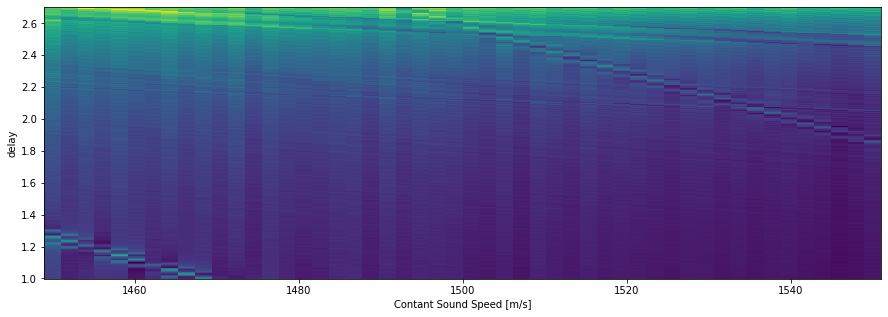

In [10]:
plt.figure(figsize=(15,5))
NCCFs.loc[:,1:2.7].plot(x='dates', y='delay', add_colorbar=False)
plt.xlabel('Contant Sound Speed [m/s]')

#plt.savefig('constant_c_fig.png', dpi=300)

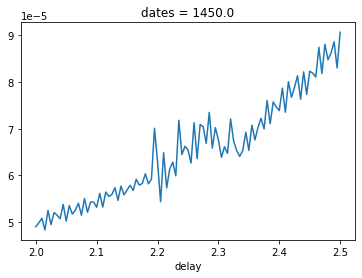

In [14]:
NCCFs[0,:].loc[2:2.5].plot()

In [88]:
C0s = (np.linspace(1450,1550, 50))

s1b0_idx1 = np.argmin(np.abs(NCCFs.delay.values - 2))
s1b0_idx2 = np.argmin(np.abs(NCCFs.delay.values - 4))

s1b0_proptime = inversion.calc_prop_time(NCCFs, 'custom', peak_slice=(s1b0_idx1, s1b0_idx2))
s1b0_proptime = s1b0_proptime.rename({'dates':'sound_speed'})
s1b0_proptime = s1b0_proptime.assign_coords({'sound_speed':C0s})

s2b1_idx1 = np.argmin(np.abs(NCCFs.delay.values - 4))
s2b1_idx2 = np.argmin(np.abs(NCCFs.delay.values - 5))

s2b1_proptime = inversion.calc_prop_time(NCCFs, 'custom', peak_slice=(s2b1_idx1, s2b1_idx2))
s2b1_proptime = s2b1_proptime.rename({'dates':'sound_speed'})
s2b1_proptime = s2b1_proptime.assign_coords({'sound_speed':C0s})

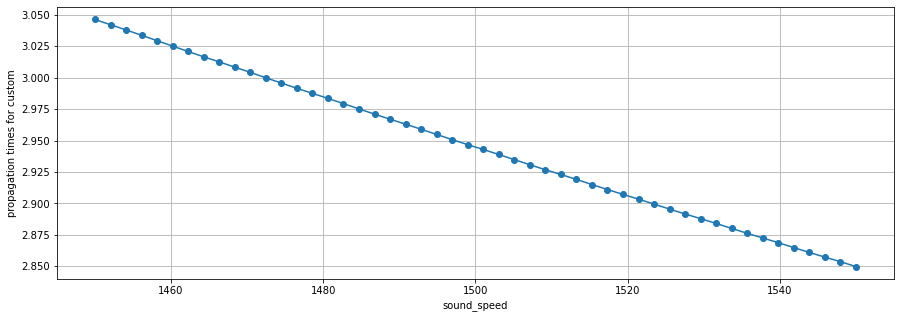

In [94]:
plt.figure(figsize=(15,5))
s1b0_proptime.plot(marker='o')
plt.grid()

## Fit linear Model

In [113]:
coefs_s1b0 = scipy.polyfit(s1b0_proptime.values, s1b0_proptime.sound_speed, 1)
coefs_s2b1 = scipy.polyfit(s2b1_proptime.values, s2b1_proptime.sound_speed, 1)

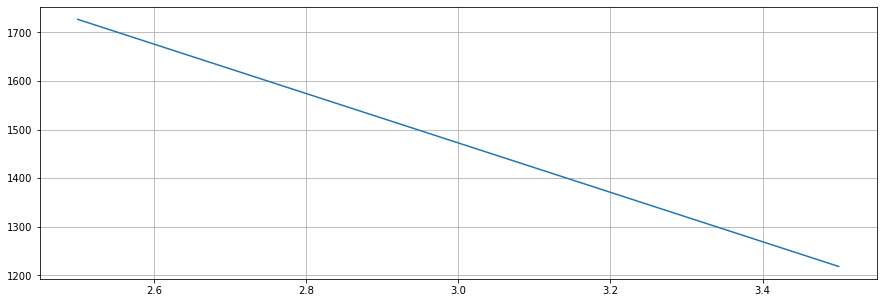

In [115]:
prop_times = np.linspace(2.5,3.5,100)

sound_speed_model = prop_times*coefs_s1b0[0] + coefs_s1b0[1]

plt.figure(figsize=(15,5))
plt.plot(prop_times, sound_speed_model)
plt.grid()

In [116]:
coefs = {
    's1b0':coefs_s1b0,
    's2b1':coefs_s2b1
}

In [118]:
fn = 'constant_c_model_coefs.pkl'

with open(fn, 'wb') as f:
    pickle.dump(coefs, f)